In [25]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.regularizers import l2
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import IPython.display
from sklearn.model_selection import train_test_split

In [11]:
# LOAD IN FILE
x, sr = librosa.load('Datasets/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')
# PLAY AUDIO FILE
IPython.display.Audio(data=x, rate=sr)

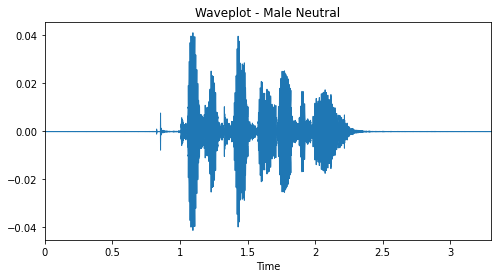

In [12]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Neutral')
plt.savefig('Waveplot_MaleNeutral.png')

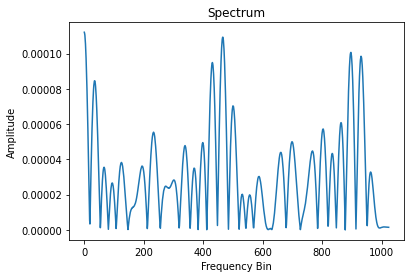

In [15]:
#Apply fouriter Transform
n_fft = 2048
ft = np.abs(librosa.stft(x[:n_fft], hop_length = n_fft+1))
plt.plot(ft);
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

/home/khalismurfid/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/khalismurfid/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


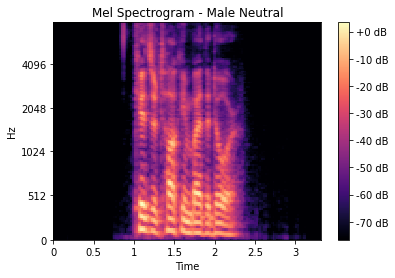

In [13]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.savefig('MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB');

In [61]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
directory = r'Datasets/'
for i in os.listdir(directory):
    filename = os.listdir(directory + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(directory + i + '/' + f)
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
print(len(audio_df))
audio_df

1440


,gender,emotion,actor,path
0,male,neutral,1,Datasets/Actor_01/03-01-01-01-01-01-01.wav
1,male,neutral,1,Datasets/Actor_01/03-01-01-01-01-02-01.wav
2,male,neutral,1,Datasets/Actor_01/03-01-01-01-02-01-01.wav
3,male,neutral,1,Datasets/Actor_01/03-01-01-01-02-02-01.wav
4,male,calm,1,Datasets/Actor_01/03-01-02-01-01-01-01.wav
...,...,...,...,...
1435,female,surprise,24,Datasets/Actor_24/03-01-08-01-02-02-24.wav
1436,female,surprise,24,Datasets/Actor_24/03-01-08-02-01-01-24.wav
1437,female,surprise,24,Datasets/Actor_24/03-01-08-02-01-02-24.wav
1438,female,surprise,24,Datasets/Actor_24/03-01-08-02-02-01-24.wav


<AxesSubplot:>

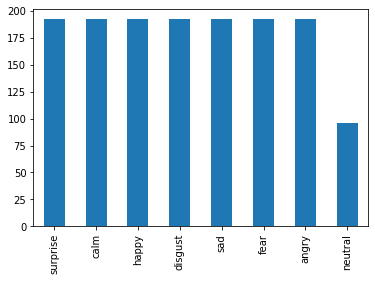

In [62]:

# LOOK AT DISTRIBUTION OF CLASSES
audio_df.emotion.value_counts().plot(kind='bar')

In [32]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1
print(len(df))
df.head()

1440


,mel_spectrogram
0,"[-76.38477, -76.38477, -76.38477, -76.38477, -..."
1,"[-75.33552, -75.44532, -75.55403, -75.20395, -..."
2,"[-75.15071, -75.15071, -75.15071, -75.15071, -..."
3,"[-75.26845, -75.26845, -75.26845, -75.26845, -..."
4,"[-80.14738, -80.14738, -80.14738, -80.14738, -..."


In [63]:
df_temp = df.copy()
df_temp_1 = pd.DataFrame(df_temp.pop('mel_spectrogram').values.tolist(), index=df_temp.index)

df_temp = df_temp.join(df_temp_1.sort_index(axis=1))
df_combined = pd.concat([audio_df, df_temp], axis=1)
df_combined = df_combined.drop('path', 1)
df_combined = df_combined.fillna(0)
df_combined.head()

,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,male,neutral,1,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male,neutral,1,-75.335518,-75.445320,-75.554031,-75.203949,-75.230530,-75.319374,-75.653793,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,neutral,1,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male,neutral,1,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male,calm,1,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,...,-80.147377,-80.147377,-80.121956,-79.998009,-80.119255,-80.147377,-80.130417,-80.014702,-80.147377,-80.147377


In [36]:
## Preprocessing

In [77]:
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])

In [78]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [79]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [80]:

# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


/home/khalismurfid/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [82]:

print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [83]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [84]:
X_train.shape

(1152, 259, 1, 1)

In [90]:
import numpy as np
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.052083333333333336

In [87]:
# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Conv1D(128, kernel_size=(10),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 250, 64)           704       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 128)           

In [92]:

import tensorflow.keras as keras

# FIT MODEL AND USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/40
36/36 [==============================] - 1s 22ms/step - loss: 2.5399 - accuracy: 0.2561 - val_loss: 2.4672 - val_accuracy: 0.2604

Epoch 00001: val_accuracy improved from -inf to 0.26042, saving model to best_initial_model.hdf5
Epoch 2/40
36/36 [==============================] - 1s 20ms/step - loss: 2.4578 - accuracy: 0.2561 - val_loss: 2.3953 - val_accuracy: 0.2639

Epoch 00002: val_accuracy improved from 0.26042 to 0.26389, saving model to best_initial_model.hdf5
Epoch 3/40
36/36 [==============================] - 1s 20ms/step - loss: 2.3987 - accuracy: 0.2665 - val_loss: 2.3445 - val_accuracy: 0.2708

Epoch 00003: val_accuracy improved from 0.26389 to 0.27083, saving model to best_initial_model.hdf5
Epoch 4/40
36/36 [==============================] - 1s 21ms/step - loss: 2.3315 - accuracy: 0.2830 - val_loss: 2.2900 - val_accuracy: 0.2604

Epoch 00004: val_accuracy did not improve from 0.27083
Epoch 5/40
36/36 [==============================] - 1s 22ms/step - loss: 2.3016 

36/36 [==============================] - 1s 24ms/step - loss: 1.6821 - accuracy: 0.3924 - val_loss: 1.6999 - val_accuracy: 0.4062

Epoch 00038: val_accuracy did not improve from 0.41667
Epoch 39/40
36/36 [==============================] - 1s 22ms/step - loss: 1.6821 - accuracy: 0.3932 - val_loss: 1.6941 - val_accuracy: 0.4097

Epoch 00039: val_accuracy did not improve from 0.41667
Epoch 40/40
36/36 [==============================] - 1s 21ms/step - loss: 1.7013 - accuracy: 0.3863 - val_loss: 1.7017 - val_accuracy: 0.4028

Epoch 00040: val_accuracy did not improve from 0.41667


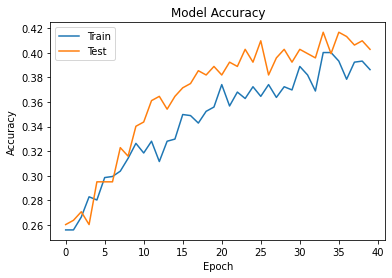

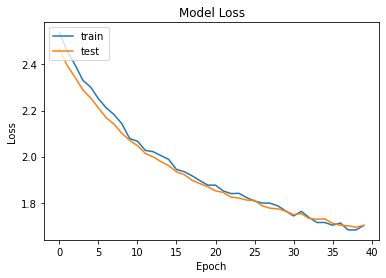

In [93]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()


In [96]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH 
finaldf = actual.join(predictions)
finaldf[32:36]

,Actual Values,Predicted Values
32,sad,surprise
33,angry,angry
34,angry,surprise
35,happy,disgust


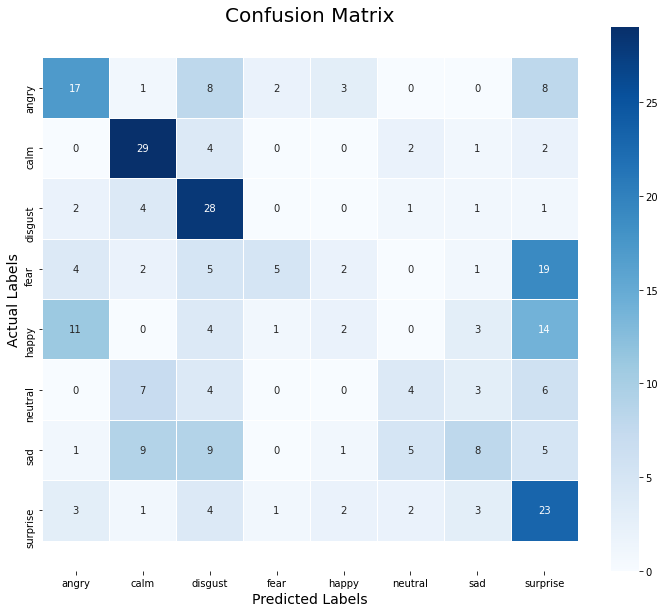

In [97]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [98]:
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.45      0.44      0.44        39
        calm       0.55      0.76      0.64        38
     disgust       0.42      0.76      0.54        37
        fear       0.56      0.13      0.21        38
       happy       0.20      0.06      0.09        35
     neutral       0.29      0.17      0.21        24
         sad       0.40      0.21      0.28        38
    surprise       0.29      0.59      0.39        39

    accuracy                           0.40       288
   macro avg       0.39      0.39      0.35       288
weighted avg       0.40      0.40      0.36       288



In [ ]:
##Tuning

In [99]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)

(1152, 259)
(288, 259)


In [100]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [101]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [102]:
# RESHAPE TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [103]:
from keras.utils import np_utils, to_categorical

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

/home/khalismurfid/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [107]:
# CREATE FUNCTION FOR KERAS CLASSIFIER
opt = keras.optimizers.Adam(lr=0.0001)
def make_classifier(optimizer=opt):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(keras.layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(keras.layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(keras.layers.MaxPooling1D(pool_size=(8)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=(8)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(8, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model

In [108]:
y_trainHot=np.argmax(y_train, axis=1)

In [109]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 32, 34],
    'nb_epoch': [25, 50, 75],
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_trainHot)

31/31 [==============================] - 1s 18ms/step - loss: 2.9125 - accuracy: 0.1443


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9186 - accuracy: 0.1599


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9009 - accuracy: 0.1688


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 19ms/step - loss: 2.9232 - accuracy: 0.1397


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9127 - accuracy: 0.1542


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9231 - accuracy: 0.1601


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.8999 - accuracy: 0.1764


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 19ms/step - loss: 2.9235 - accuracy: 0.1484


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 17ms/step - loss: 2.9314 - accuracy: 0.1508


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 17ms/step - loss: 2.9065 - accuracy: 0.1433


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.8856 - accuracy: 0.1847


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.8931 - accuracy: 0.1670


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9330 - accuracy: 0.1390


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9240 - accuracy: 0.1383


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 17ms/step - loss: 2.9162 - accuracy: 0.1613


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9388 - accuracy: 0.1206


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 17ms/step - loss: 2.9371 - accuracy: 0.1509


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.8973 - accuracy: 0.1458


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9292 - accuracy: 0.1388


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9146 - accuracy: 0.1406


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 17ms/step - loss: 2.9252 - accuracy: 0.1756


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 17ms/step - loss: 2.9207 - accuracy: 0.1423


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.8934 - accuracy: 0.1490


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 19ms/step - loss: 2.9069 - accuracy: 0.1897


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 17ms/step - loss: 2.8954 - accuracy: 0.1587


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9285 - accuracy: 0.1499


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 19ms/step - loss: 2.8976 - accuracy: 0.1297


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 19ms/step - loss: 2.9232 - accuracy: 0.1257


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9136 - accuracy: 0.1406


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


31/31 [==============================] - 1s 18ms/step - loss: 2.9046 - accuracy: 0.1730


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9140 - accuracy: 0.1561


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9344 - accuracy: 0.1379


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 19ms/step - loss: 2.8986 - accuracy: 0.1551


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 19ms/step - loss: 2.9364 - accuracy: 0.1203


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 20ms/step - loss: 2.8999 - accuracy: 0.1673


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 19ms/step - loss: 2.9020 - accuracy: 0.1437


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 19ms/step - loss: 2.9221 - accuracy: 0.1654


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 19ms/step - loss: 2.8976 - accuracy: 0.1497


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 20ms/step - loss: 2.9014 - accuracy: 0.1737


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9141 - accuracy: 0.1514


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9335 - accuracy: 0.1349


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 20ms/step - loss: 2.9260 - accuracy: 0.1466


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 19ms/step - loss: 2.8984 - accuracy: 0.1391


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9319 - accuracy: 0.1289


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.8935 - accuracy: 0.1727


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9134 - accuracy: 0.1612


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 19ms/step - loss: 2.8973 - accuracy: 0.1654


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 19ms/step - loss: 2.9803 - accuracy: 0.1411


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9057 - accuracy: 0.1537


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 19ms/step - loss: 2.9257 - accuracy: 0.1362


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9208 - accuracy: 0.1392


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 20ms/step - loss: 2.9602 - accuracy: 0.1159


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 19ms/step - loss: 2.9174 - accuracy: 0.1351


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9202 - accuracy: 0.1364


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 21ms/step - loss: 2.9076 - accuracy: 0.1813


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9143 - accuracy: 0.1508


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9098 - accuracy: 0.1758


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 20ms/step - loss: 2.8857 - accuracy: 0.2090


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 20ms/step - loss: 2.9185 - accuracy: 0.1481


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


29/29 [==============================] - 1s 18ms/step - loss: 2.9090 - accuracy: 0.1301


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9100 - accuracy: 0.1627


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 20ms/step - loss: 2.9159 - accuracy: 0.1238


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9264 - accuracy: 0.1491


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9241 - accuracy: 0.1761


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 20ms/step - loss: 2.9515 - accuracy: 0.1234


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 20ms/step - loss: 2.9131 - accuracy: 0.1355


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 18ms/step - loss: 2.9274 - accuracy: 0.1530


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 20ms/step - loss: 2.9131 - accuracy: 0.1447


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 18ms/step - loss: 2.9297 - accuracy: 0.1581


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.8913 - accuracy: 0.1666


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 18ms/step - loss: 2.9279 - accuracy: 0.1414


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 18ms/step - loss: 2.9181 - accuracy: 0.1415


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9333 - accuracy: 0.1452


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 21ms/step - loss: 2.9197 - accuracy: 0.1382


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9242 - accuracy: 0.1534


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9317 - accuracy: 0.1342


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 21ms/step - loss: 2.9181 - accuracy: 0.1569


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9117 - accuracy: 0.1633


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9224 - accuracy: 0.1512


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 18ms/step - loss: 2.8926 - accuracy: 0.1883


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 21ms/step - loss: 2.9276 - accuracy: 0.1361


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 20ms/step - loss: 2.9209 - accuracy: 0.1368


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9261 - accuracy: 0.1439


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9170 - accuracy: 0.1502


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 20ms/step - loss: 2.9373 - accuracy: 0.1546


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 20ms/step - loss: 2.9061 - accuracy: 0.1756


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9094 - accuracy: 0.1671


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9172 - accuracy: 0.1382


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 20ms/step - loss: 2.9288 - accuracy: 0.1482


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


28/28 [==============================] - 1s 19ms/step - loss: 2.9174 - accuracy: 0.1513


/home/khalismurfid/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


39/39 [==============================] - 1s 18ms/step - loss: 2.9022 - accuracy: 0.1818


In [110]:
grid_search.best_params_

{'batch_size': 30, 'nb_epoch': 25, 'optimizer': 'adam'}

In [111]:

grid_search.best_score_

0.25870506305288915

In [115]:
# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Conv1D(128, kernel_size=(10),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_288 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_289 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_192 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_288 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_290 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_193 (MaxPoolin (None, 2, 128)            0         
_________________________________________________________________
dropout_289 (Dropout)        (None, 2, 128)         

In [116]:
model.fit(X_train, y_train,batch_size=30, epochs=100, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/100
39/39 [==============================] - 1s 21ms/step - loss: 2.8914 - accuracy: 0.1764 - val_loss: 2.7769 - val_accuracy: 0.2292

Epoch 00001: val_accuracy did not improve from 0.45486
Epoch 2/100
39/39 [==============================] - 1s 18ms/step - loss: 2.7410 - accuracy: 0.2140 - val_loss: 2.6126 - val_accuracy: 0.2500

Epoch 00002: val_accuracy did not improve from 0.45486
Epoch 3/100
39/39 [==============================] - 1s 18ms/step - loss: 2.6219 - accuracy: 0.2428 - val_loss: 2.4934 - val_accuracy: 0.2812

Epoch 00003: val_accuracy did not improve from 0.45486
Epoch 4/100
39/39 [==============================] - 1s 19ms/step - loss: 2.4996 - accuracy: 0.2521 - val_loss: 2.4145 - val_accuracy: 0.2951

Epoch 00004: val_accuracy did not improve from 0.45486
Epoch 5/100
39/39 [==============================] - 1s 19ms/step - loss: 2.4091 - accuracy: 0.2574 - val_loss: 2.3414 - val_accuracy: 0.2951

Epoch 00005: val_accuracy did not improve from 0.45486
Epoch 6/10

39/39 [==============================] - 1s 19ms/step - loss: 1.7147 - accuracy: 0.3840 - val_loss: 1.6275 - val_accuracy: 0.4444

Epoch 00042: val_accuracy did not improve from 0.45486
Epoch 43/100
39/39 [==============================] - 1s 21ms/step - loss: 1.6680 - accuracy: 0.3910 - val_loss: 1.6198 - val_accuracy: 0.4479

Epoch 00043: val_accuracy did not improve from 0.45486
Epoch 44/100
39/39 [==============================] - 1s 19ms/step - loss: 1.6221 - accuracy: 0.4338 - val_loss: 1.5921 - val_accuracy: 0.4340

Epoch 00044: val_accuracy did not improve from 0.45486
Epoch 45/100
39/39 [==============================] - 1s 19ms/step - loss: 1.6638 - accuracy: 0.3855 - val_loss: 1.5966 - val_accuracy: 0.4479

Epoch 00045: val_accuracy did not improve from 0.45486
Epoch 46/100
39/39 [==============================] - 1s 19ms/step - loss: 1.6756 - accuracy: 0.3832 - val_loss: 1.5949 - val_accuracy: 0.4583

Epoch 00046: val_accuracy improved from 0.45486 to 0.45833, saving model 

39/39 [==============================] - 1s 20ms/step - loss: 1.4447 - accuracy: 0.4670 - val_loss: 1.4133 - val_accuracy: 0.4931

Epoch 00082: val_accuracy improved from 0.48611 to 0.49306, saving model to best_initial_model.hdf5
Epoch 83/100
39/39 [==============================] - 1s 19ms/step - loss: 1.4238 - accuracy: 0.4590 - val_loss: 1.4101 - val_accuracy: 0.4826

Epoch 00083: val_accuracy did not improve from 0.49306
Epoch 84/100
39/39 [==============================] - 1s 19ms/step - loss: 1.3980 - accuracy: 0.4780 - val_loss: 1.3938 - val_accuracy: 0.4896

Epoch 00084: val_accuracy did not improve from 0.49306
Epoch 85/100
39/39 [==============================] - 1s 19ms/step - loss: 1.4056 - accuracy: 0.4867 - val_loss: 1.4149 - val_accuracy: 0.5069

Epoch 00085: val_accuracy improved from 0.49306 to 0.50694, saving model to best_initial_model.hdf5
Epoch 86/100
39/39 [==============================] - 1s 19ms/step - loss: 1.4398 - accuracy: 0.4724 - val_loss: 1.4052 - val_a

In [117]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH 
finaldf = actual.join(predictions)
finaldf[32:36]

,Actual Values,Predicted Values
32,fear,happy
33,happy,angry
34,disgust,disgust
35,calm,calm


In [118]:
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.61      0.67      0.64        33
        calm       0.58      0.76      0.66        38
     disgust       0.65      0.65      0.65        43
        fear       0.75      0.33      0.45        46
       happy       0.29      0.22      0.25        32
     neutral       0.33      0.65      0.43        23
         sad       0.38      0.19      0.25        42
    surprise       0.42      0.65      0.51        31

    accuracy                           0.50       288
   macro avg       0.50      0.51      0.48       288
weighted avg       0.52      0.50      0.48       288

